In [1]:
%%capture
!pip install --upgrade covsirphy scikit-learn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

import covsirphy as cs

#optional
plt.style.use("plot_style.txt")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [3]:
print(cs.__citation__)


CovsirPhy Development Team (2020-2021), CovsirPhy version 2.22.0: Python library for COVID-19 analysis with phase-dependent SIR-derived ODE models, https://github.com/lisphilar/covid19-sir
Hirokazu Takaya (2020-2021), Kaggle Notebook, COVID-19 data with SIR model, https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model



## Estimasi Tingkat Vaksinasi ($v$)

In [4]:
kawalcovid_sheet_params = {
    "key": "1ma1T9hWbec1pXlwZ89WakRk-OfVUQZsOCFl4FwZxzVw",
    "gid": "387345074"
}

df = pd.read_csv(f"https://spreadsheets.google.com/feeds/download/spreadsheets/Export?key={kawalcovid_sheet_params['key']}&exportFormat=csv&gid={kawalcovid_sheet_params['gid']}")

In [5]:
df_vaksin = df[["Dosis pertama"]].copy()
df_vaksin = df_vaksin.dropna()
df_vaksin["Dosis pertama"] = df_vaksin["Dosis pertama"].str.replace(',', '')
df_vaksin = df_vaksin.astype('int')

df_vaksin.head()

,Dosis pertama
316,66
317,7760
318,18958
319,24414
320,24540


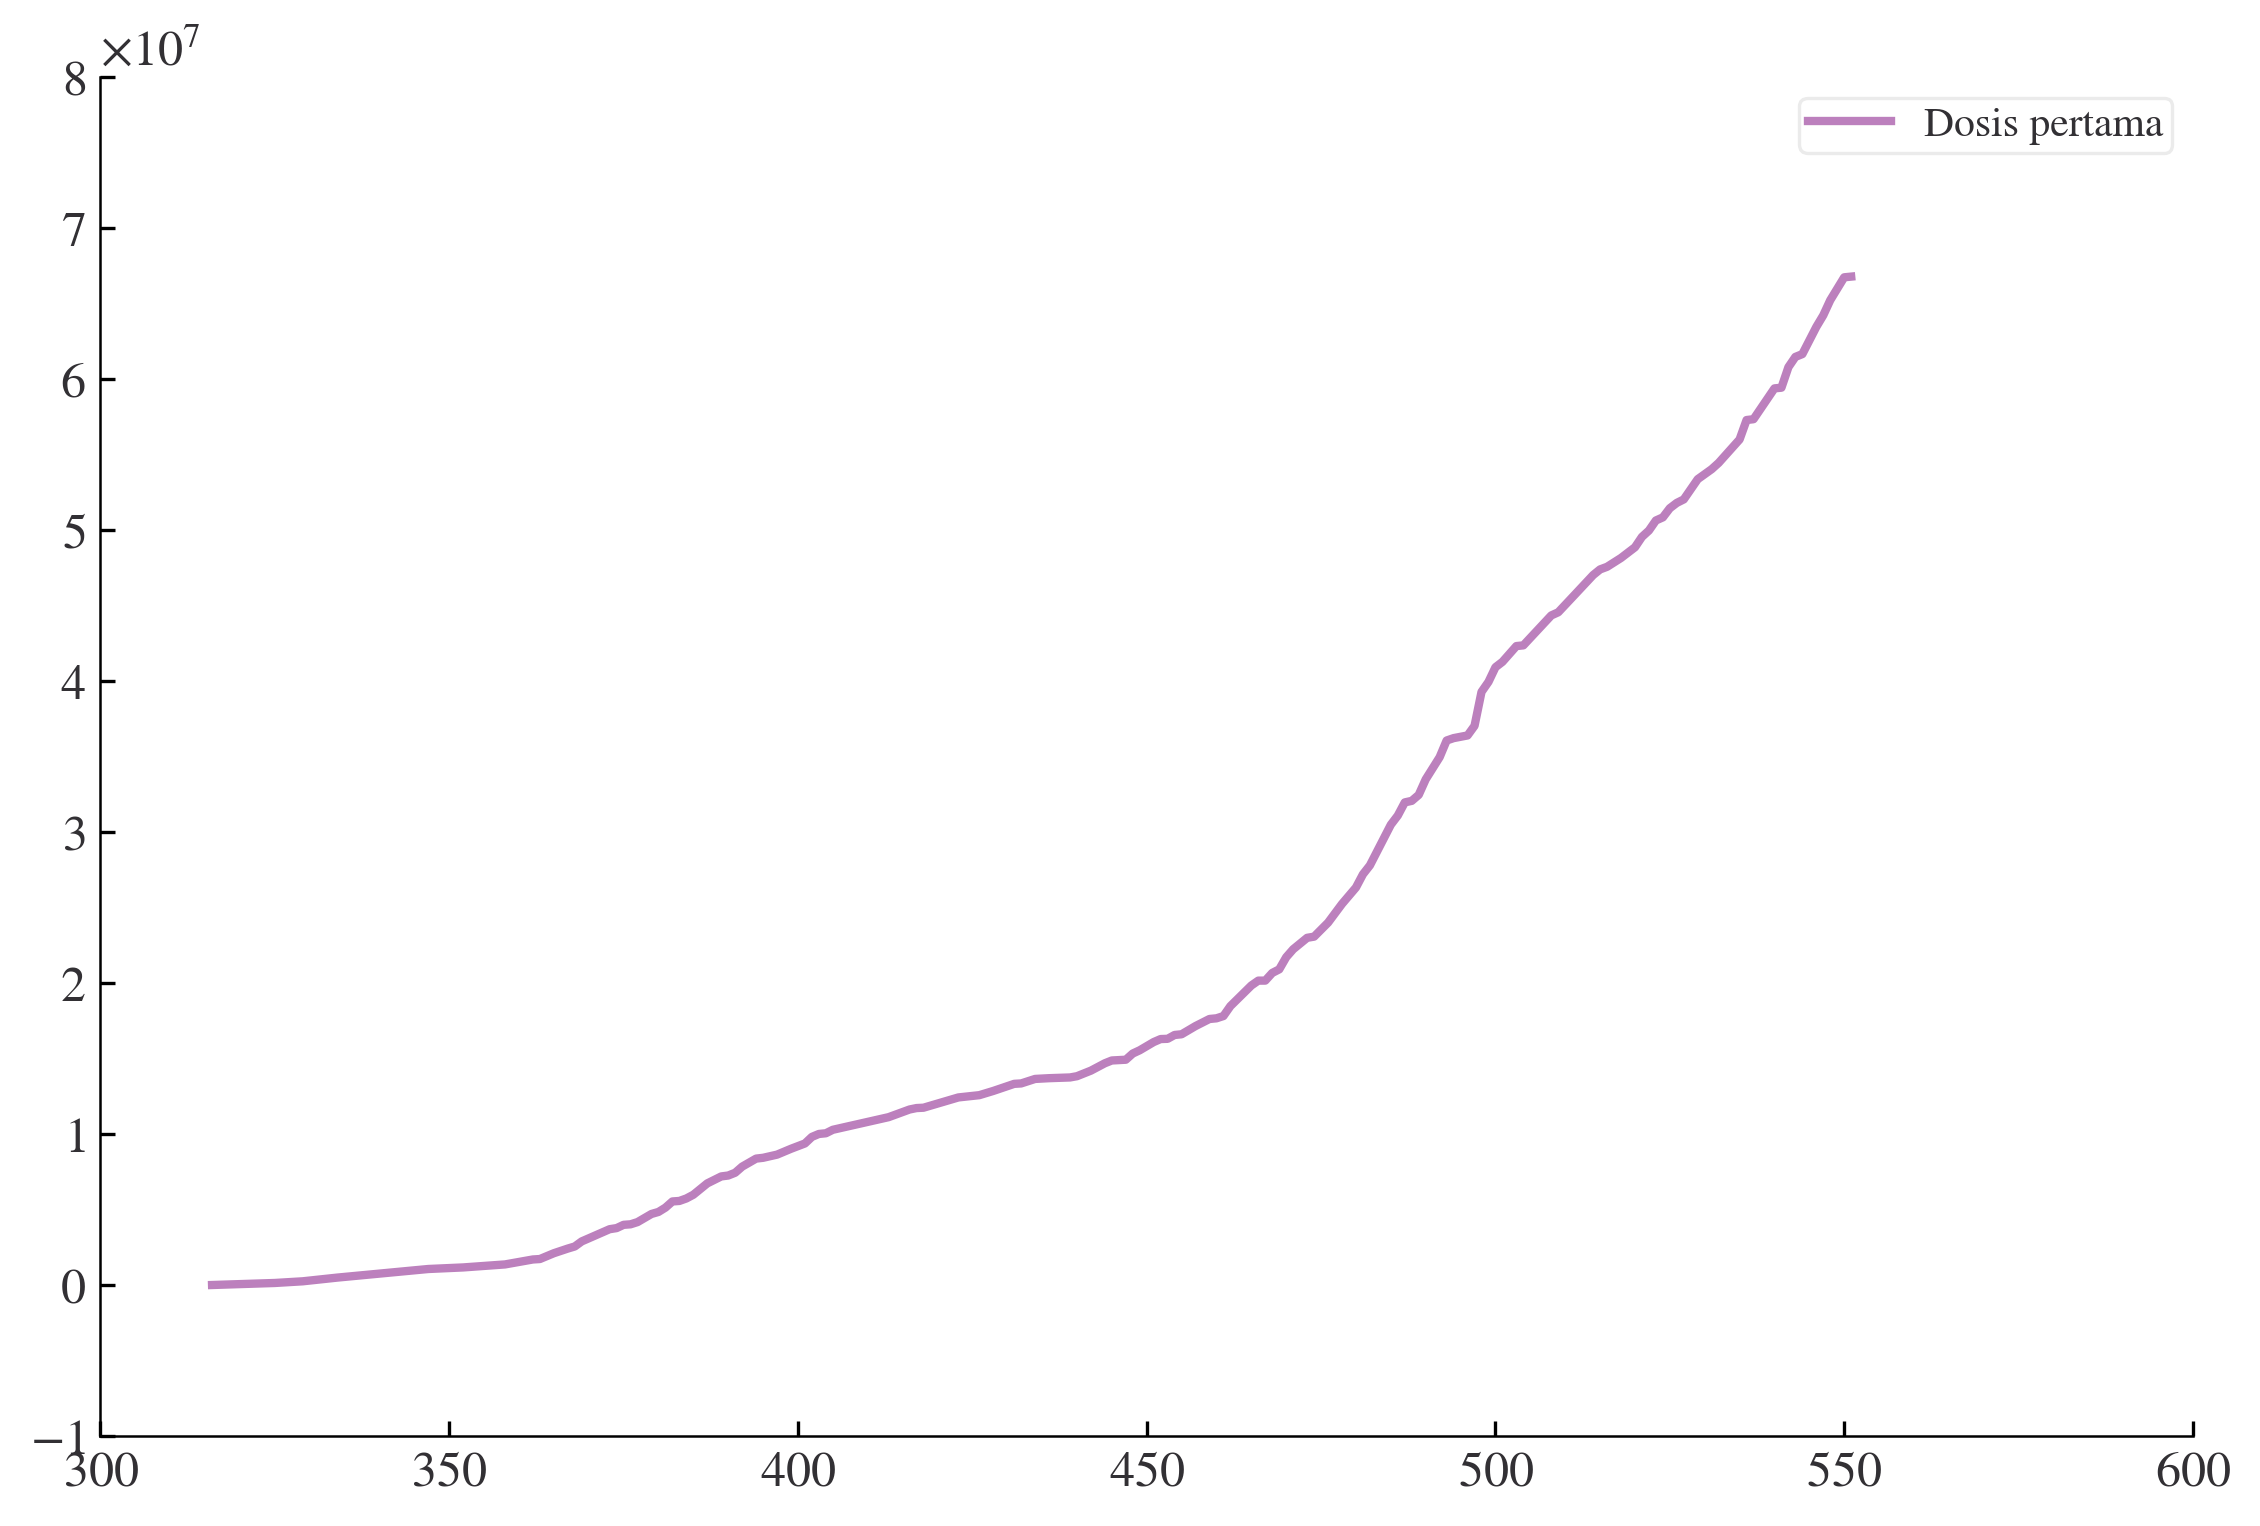

In [6]:
df_vaksin.plot()

In [7]:
X = sm.add_constant(np.arange(1, len(df_vaksin) + 1).reshape(-1, 1))
y = df_vaksin.iloc[:, 0].values.reshape(-1, 1)

In [8]:
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

In [9]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     1914.
Date:                Sat, 11 Sep 2021   Prob (F-statistic):          1.26e-114
Time:                        11:19:19   Log-Likelihood:                 216.65
No. Observations:                 236   AIC:                            -429.3
Df Residuals:                     234   BIC:                            -422.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1737      0.013    -13.709      0.0

Text(1.0, 1.0, 'Fitted $v$')

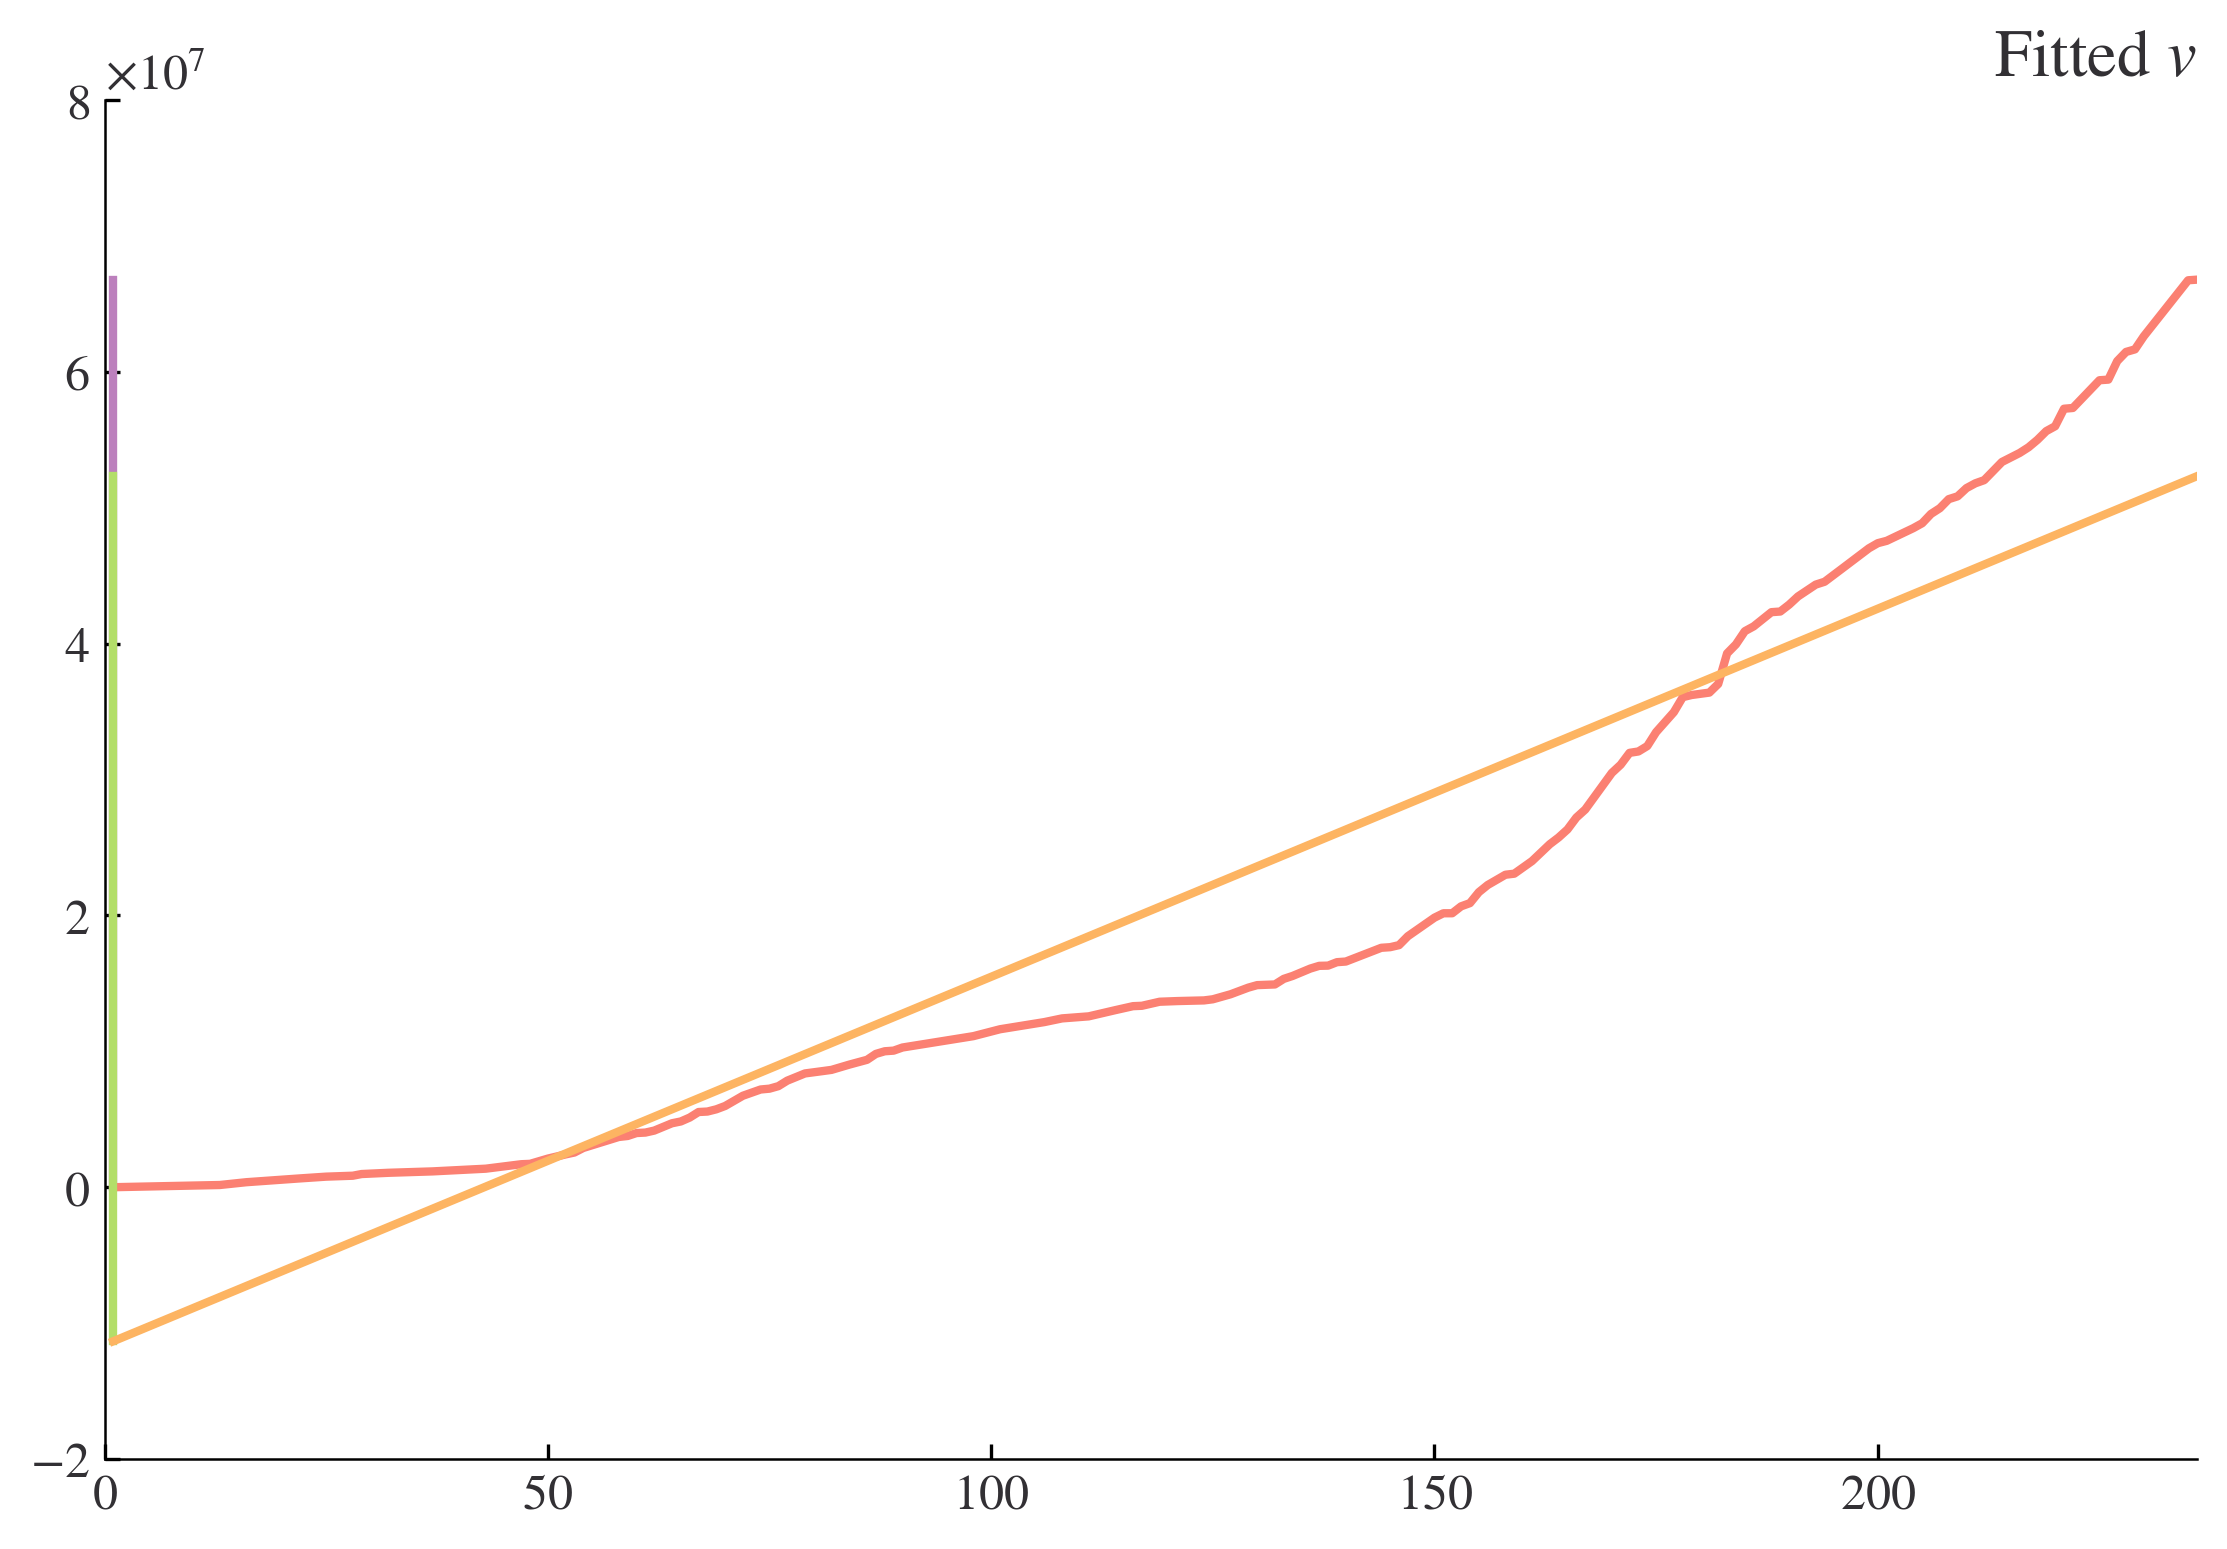

In [10]:
y_pred = scaler.inverse_transform(results.predict(X).reshape(-1, 1))
plt.plot(X, scaler.inverse_transform(y))
plt.plot(X, y_pred)
plt.xlim(0, len(y_pred))
plt.title("Fitted $v$")

## Estimasi Tingkat Transmisi ($\beta$) dan Pemulihan ($\gamma$)

In [11]:
# Download and update datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()

Retrieving COVID-19 dataset in Japan from https://github.com/lisphilar/covid19-sir/data/japan
Retrieving datasets from COVID-19 Data Hub https://covid19datahub.io/
	Please set verbose=2 to see the detailed citation list.
Retrieving datasets from Our World In Data https://github.com/owid/covid-19-data/
Retrieving datasets from COVID-19 Open Data by Google Cloud Platform https://github.com/GoogleCloudPlatform/covid-19-open-data


In [12]:
# Select country name and register the data
snl = cs.Scenario(country="Indonesia")
snl.register(jhu_data)

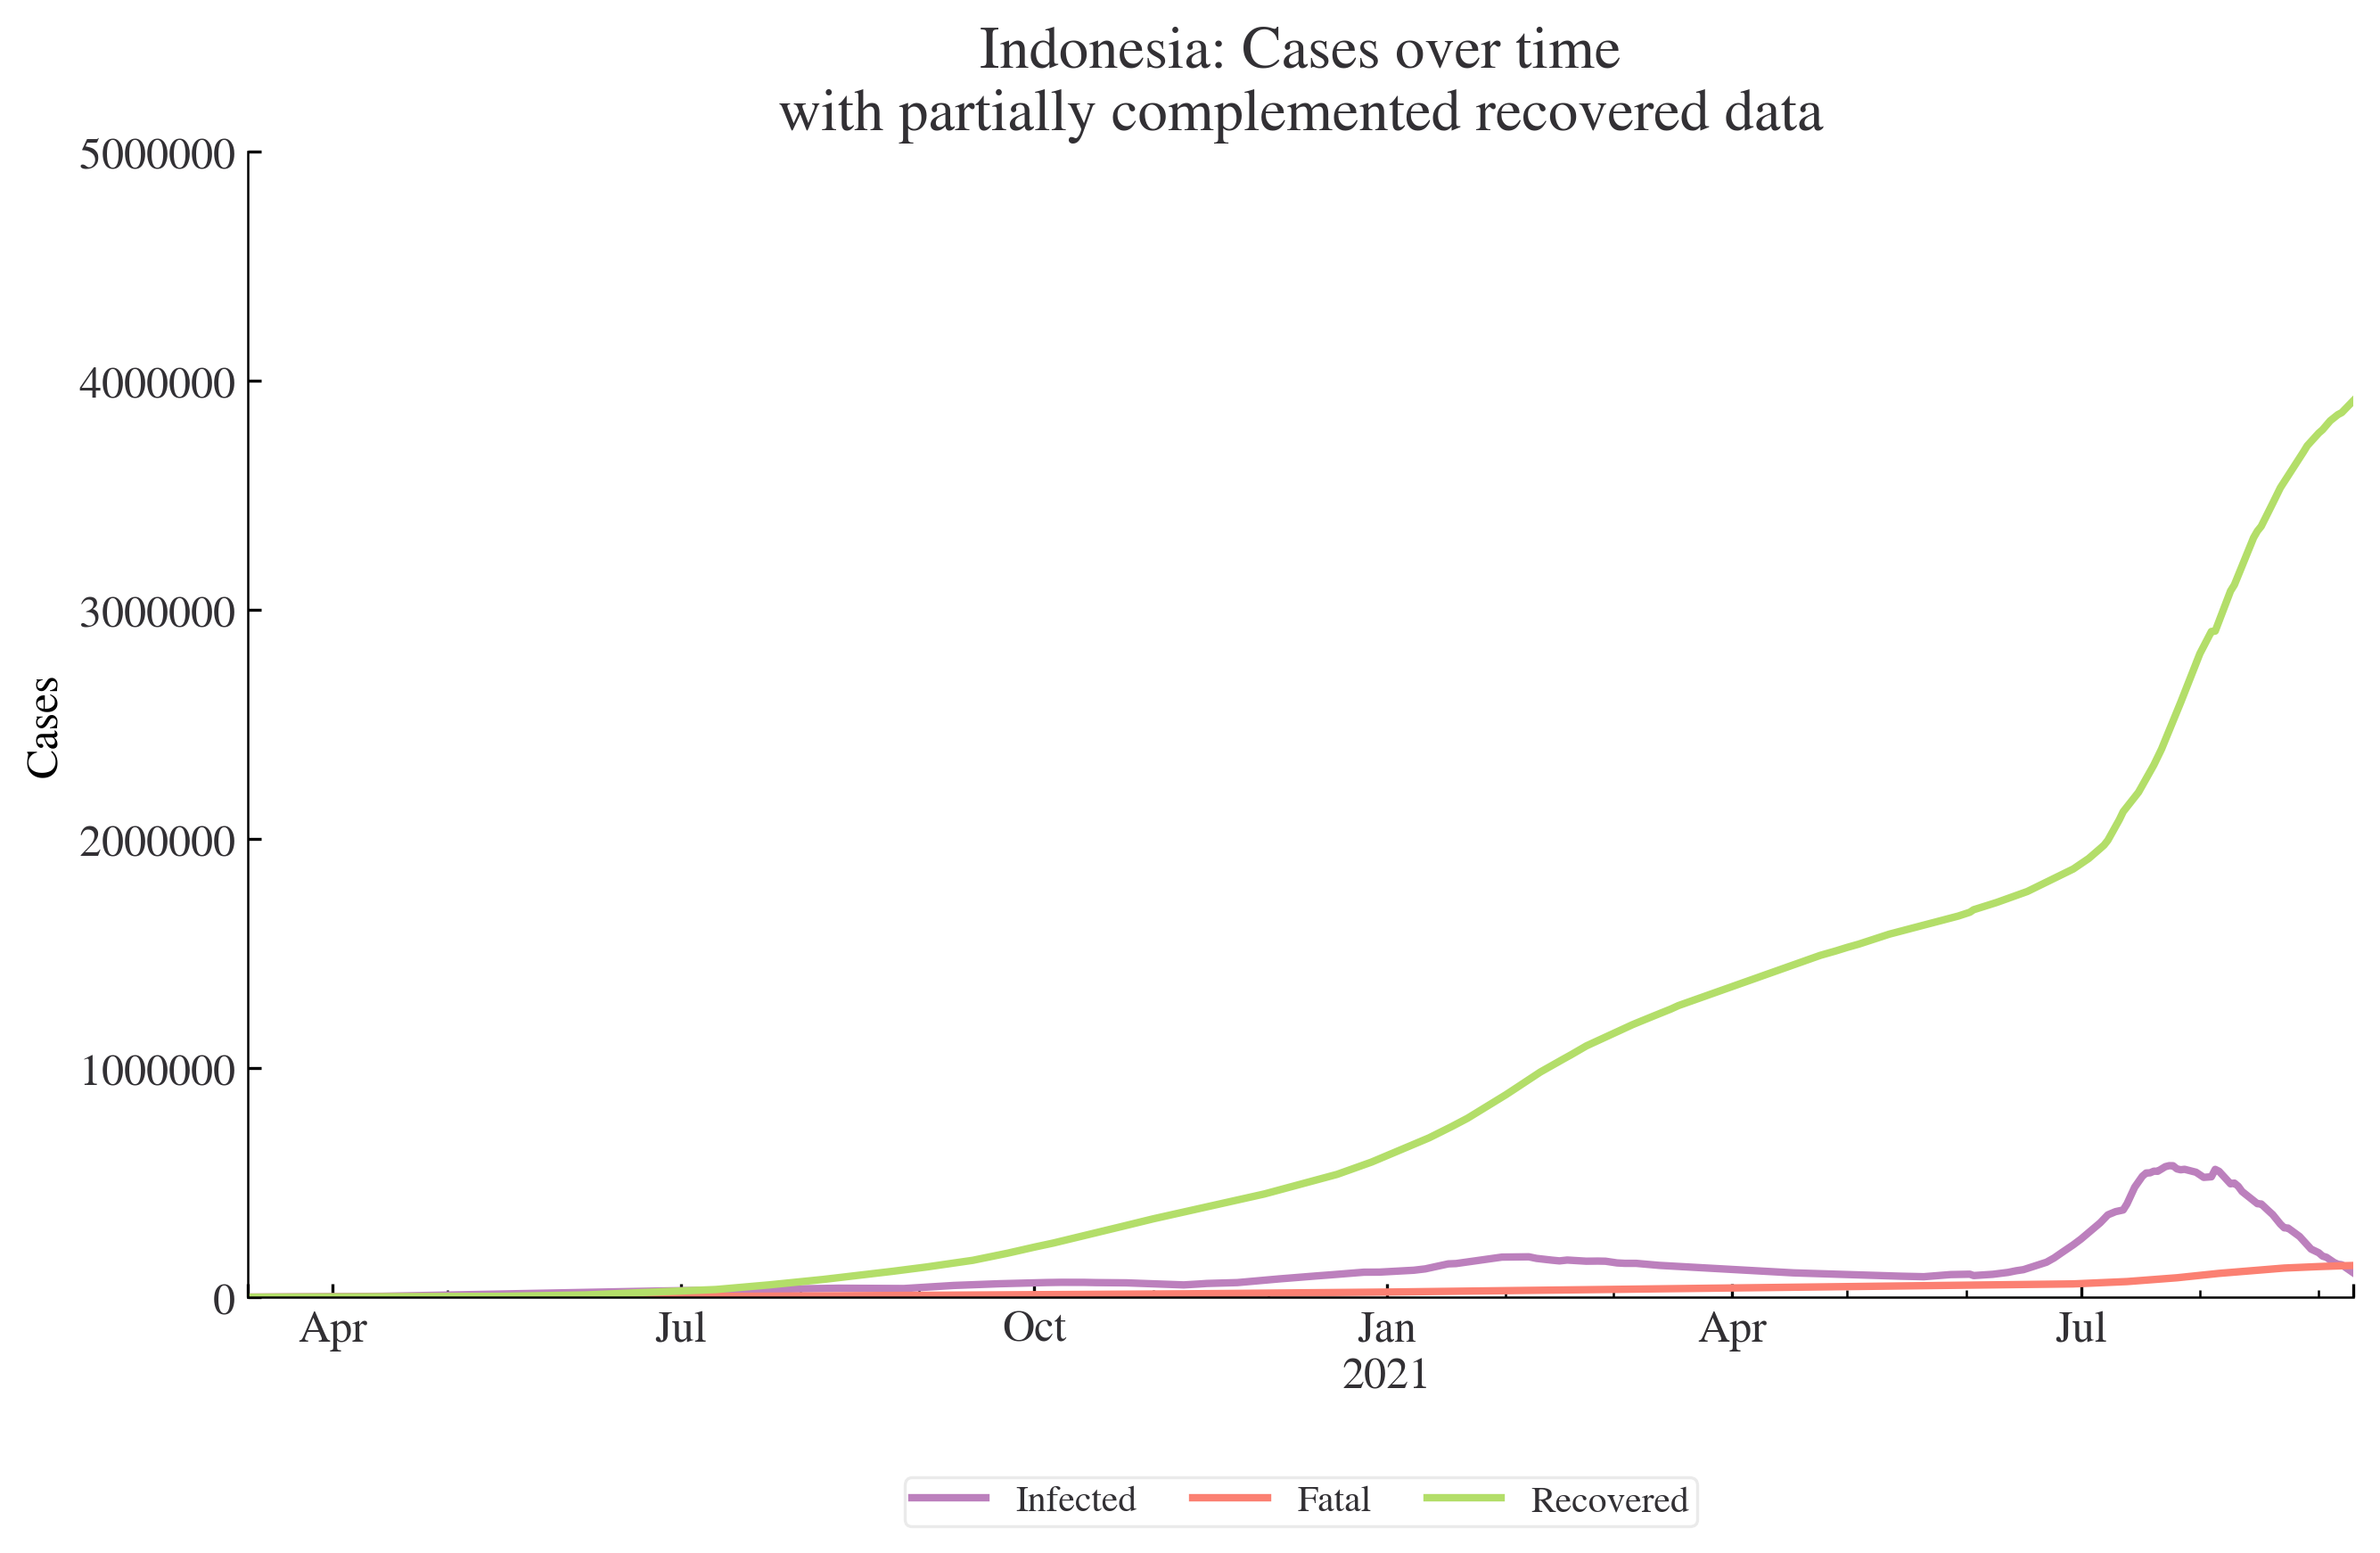

,Date,Infected,Fatal,Recovered
545,2021-09-06,143876,136473,3853084
546,2021-09-07,141632,137156,3861846
547,2021-09-08,129669,137782,3879914
548,2021-09-09,117695,138116,3897544
549,2021-09-10,106746,138431,3913554


In [13]:
# Check records
df = snl.records()
df.tail()

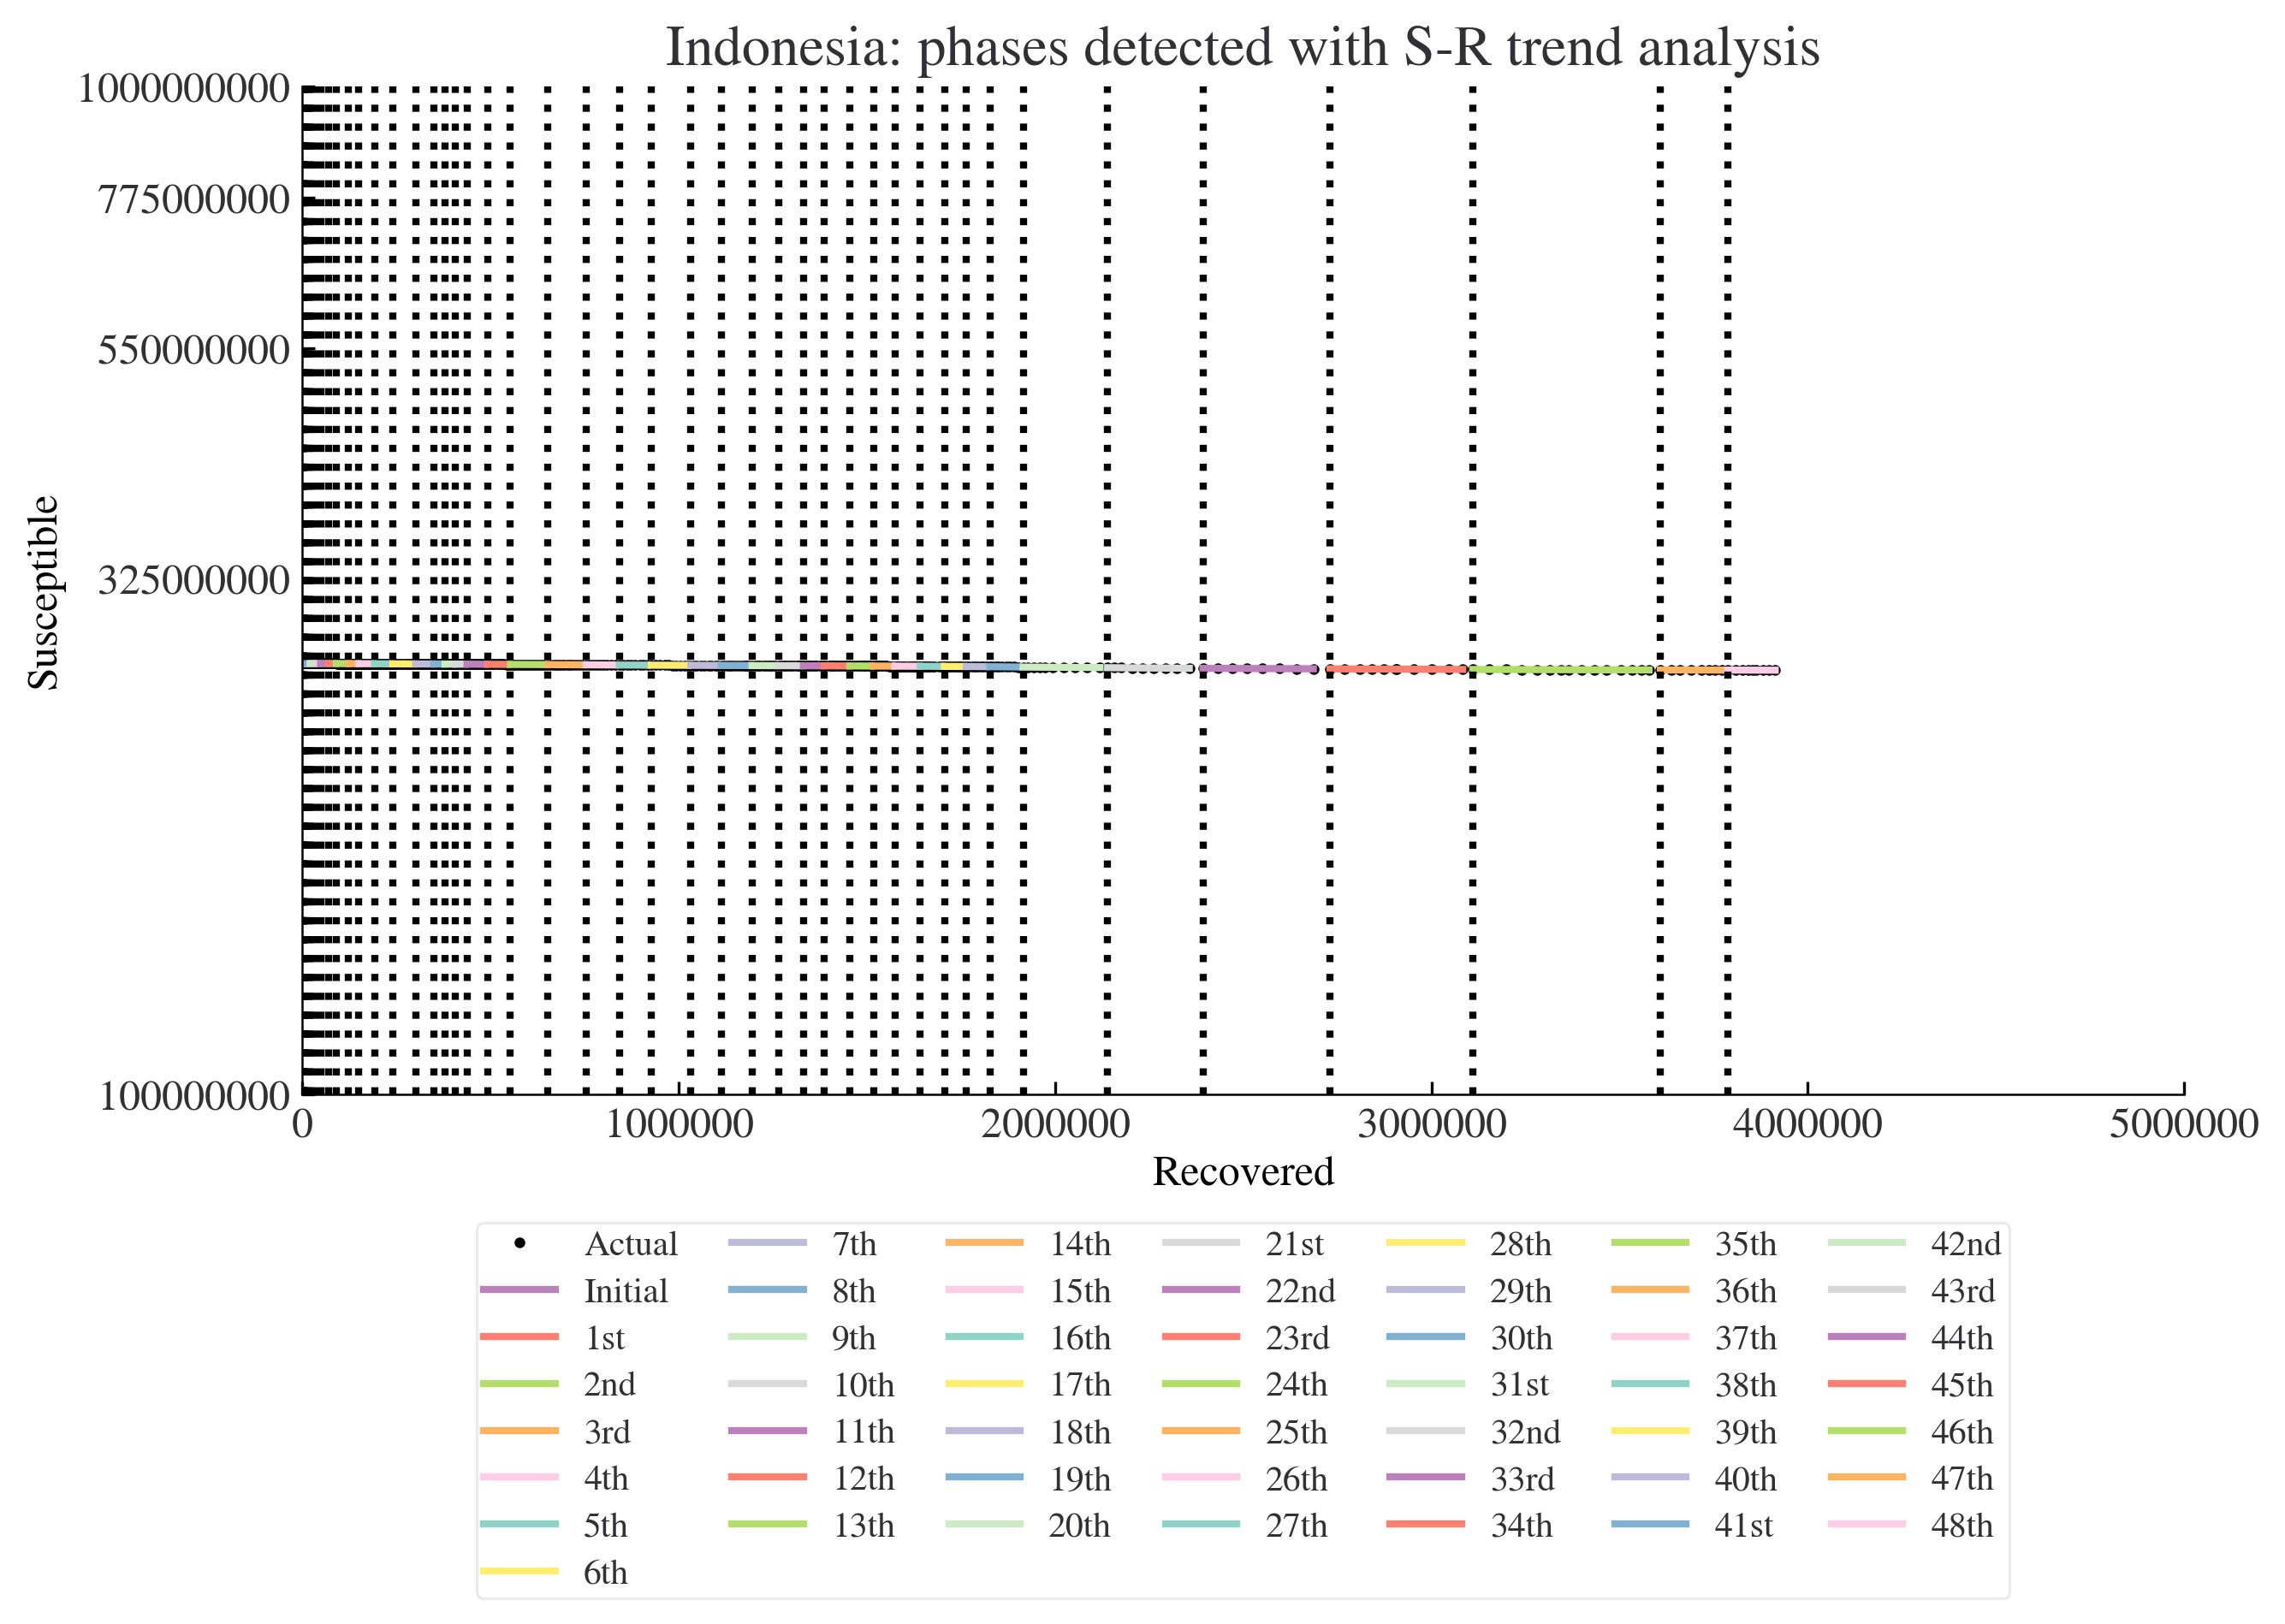

In [14]:
_ = snl.trend()

In [15]:
snl.summary().tail()

,Type,Start,End,Population
44th,Past,22Jul2021,29Jul2021,267663435
45th,Past,30Jul2021,09Aug2021,267663435
46th,Past,10Aug2021,24Aug2021,267663435
47th,Past,25Aug2021,01Sep2021,267663435
48th,Past,02Sep2021,10Sep2021,267663435


In [16]:
# Parameter estimation of SIR-F model
snl.estimate(cs.SIR)


<SIR model: parameter estimation>
Running optimization with 2 CPUs...
	 7th phase (28May2020 - 11Jun2020): finished  361 trials in 0 min  8 sec
	 0th phase (10Mar2020 - 21Mar2020): finished  428 trials in 0 min 10 sec
	 1st phase (22Mar2020 - 30Mar2020): finished  198 trials in 0 min  4 sec
	 8th phase (12Jun2020 - 24Jun2020): finished  323 trials in 0 min  7 sec
	 9th phase (25Jun2020 - 07Jul2020): finished   54 trials in 0 min  1 sec
	 2nd phase (31Mar2020 - 07Apr2020): finished  323 trials in 0 min  7 sec
	10th phase (08Jul2020 - 20Jul2020): finished  321 trials in 0 min  7 sec
	11th phase (21Jul2020 - 01Aug2020): finished   53 trials in 0 min  1 sec
	12th phase (02Aug2020 - 13Aug2020): finished   55 trials in 0 min  1 sec
	 3rd phase (08Apr2020 - 15Apr2020): finished  358 trials in 0 min  8 sec
	13th phase (14Aug2020 - 28Aug2020): finished  397 trials in 0 min  9 sec
	 4th phase (16Apr2020 - 29Apr2020): finished  280 trials in 0 min  6 sec
	14th phase (29Aug2020 - 10Sep2020): fini

(0.0, 49.0)

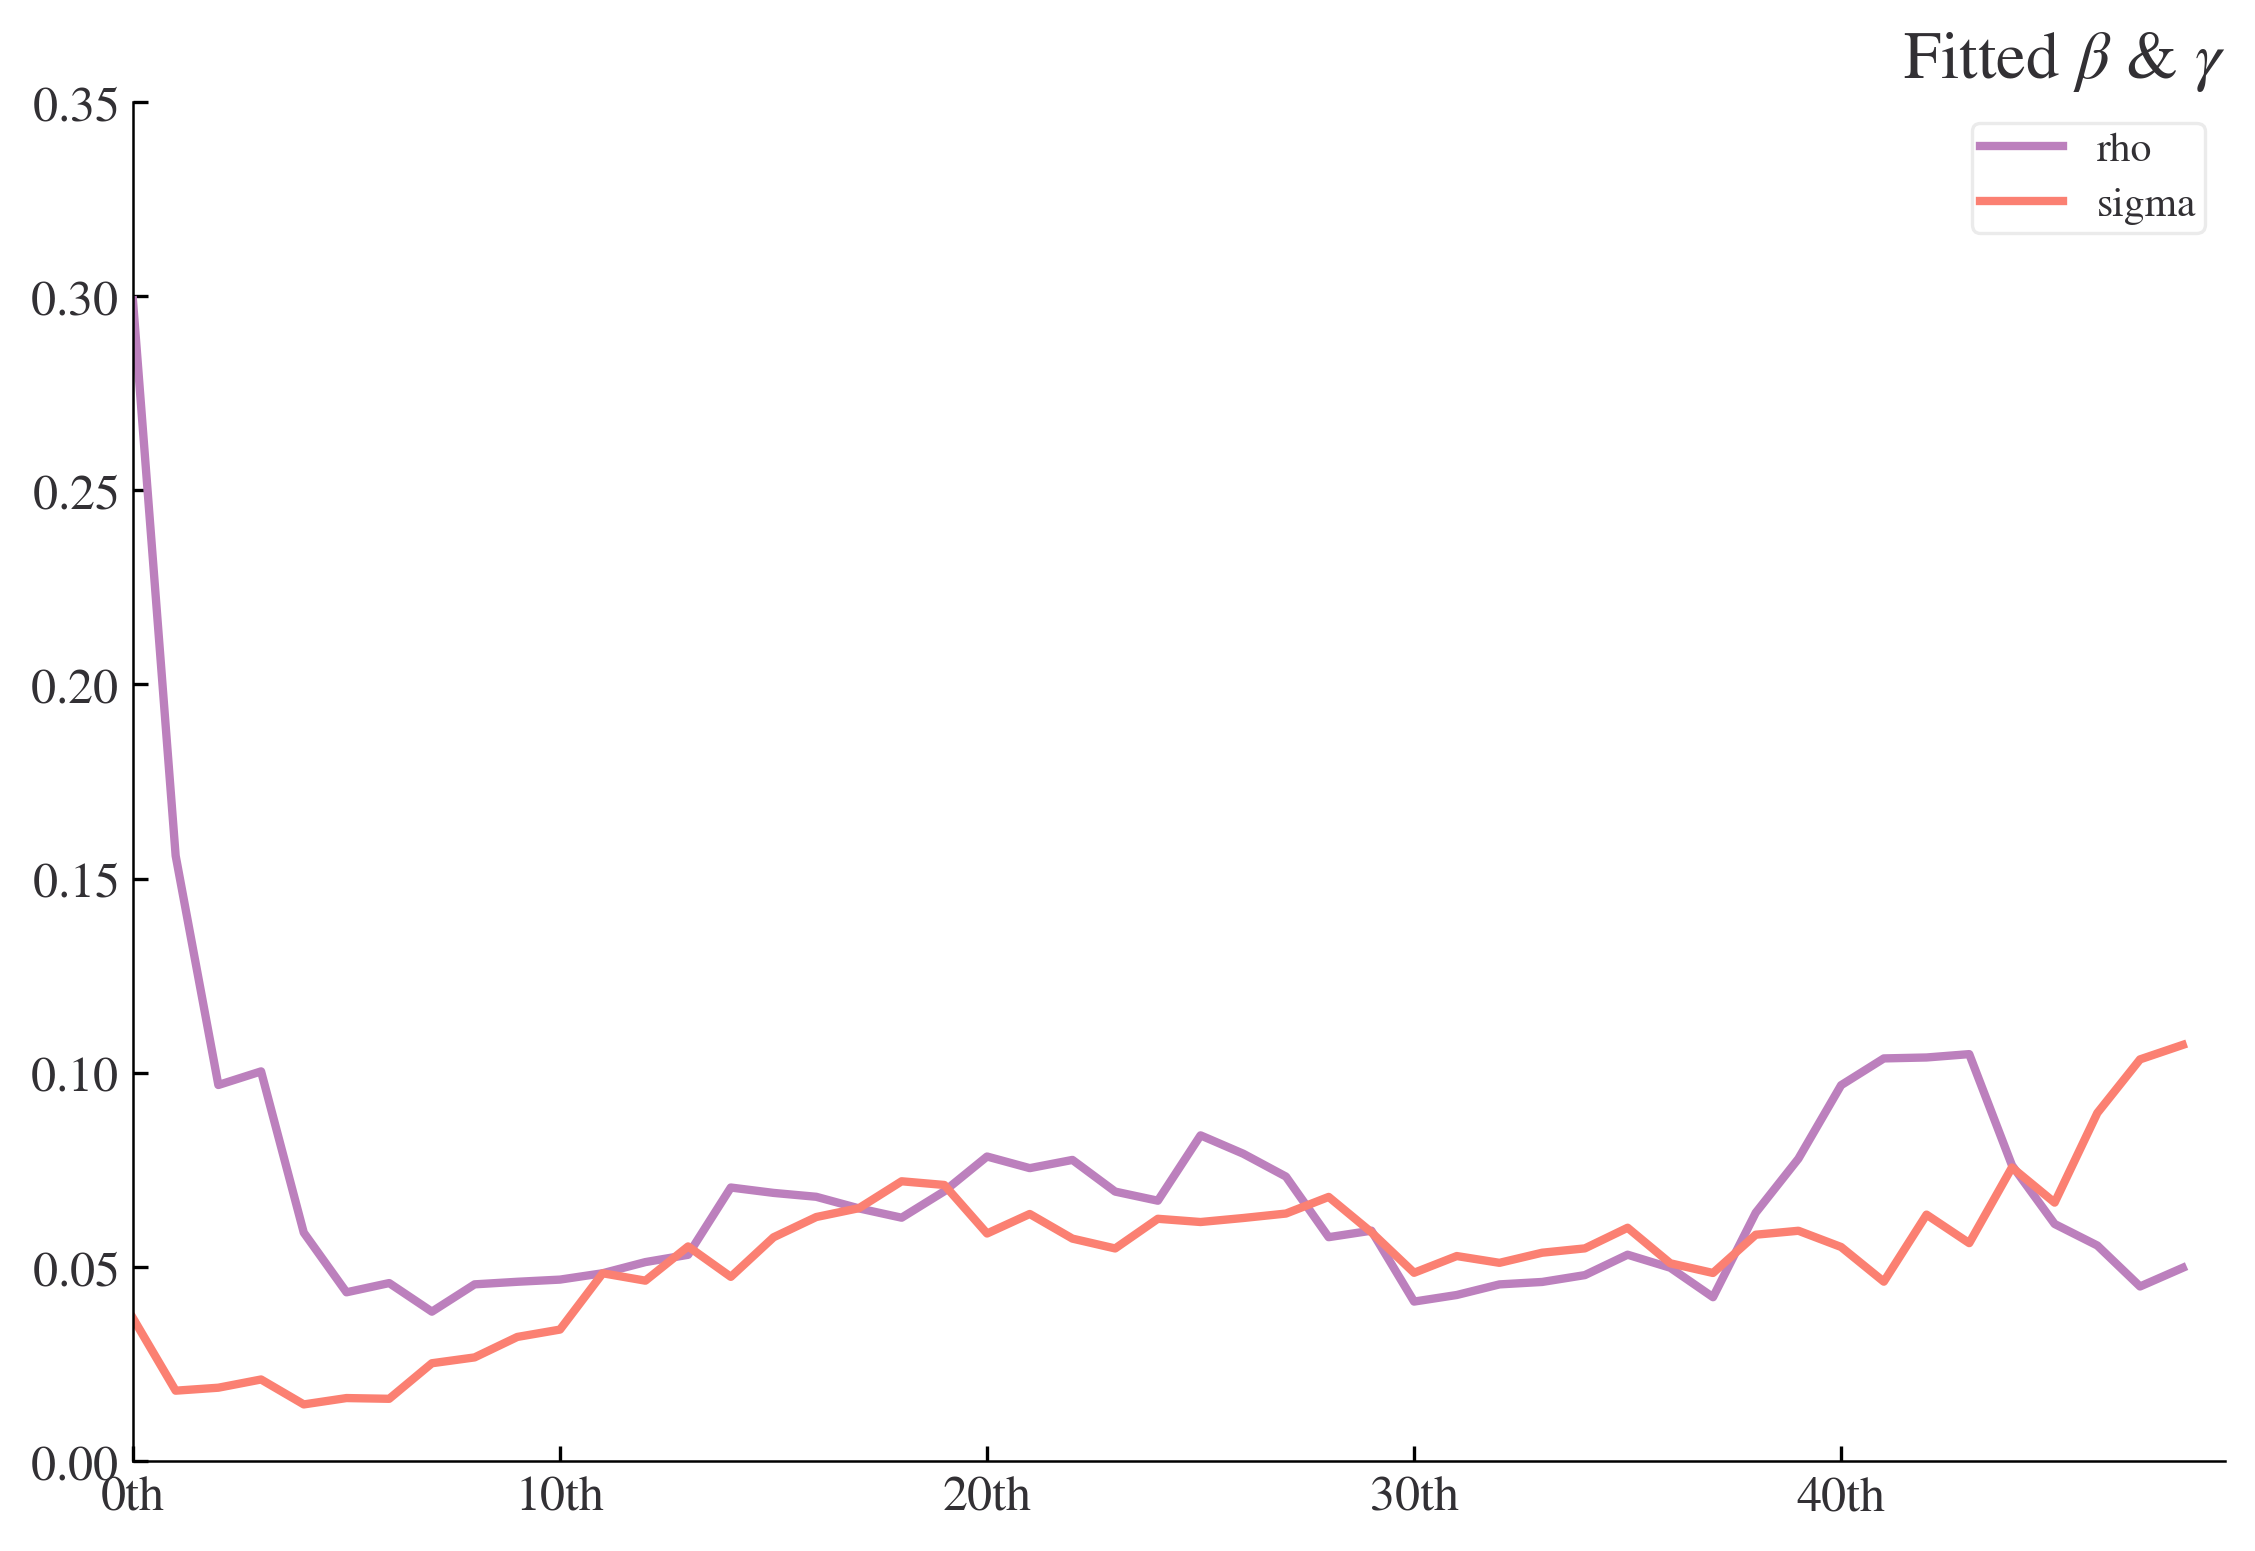

In [17]:
sumdf = snl.summary()
sumdf.to_csv("estimated.csv")

sumdf[["rho", "sigma"]].plot(title="Fitted $\\beta$ & $\\gamma$")
plt.xlim(0, len(sumdf))

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=sumdf.index, y=sumdf["rho"], mode='lines+markers', name='Rho'))
fig.add_trace(go.Scatter(x=sumdf.index, y=sumdf["sigma"], mode='lines+markers', name='Sigma'))
fig.show()

In [19]:
sumdf.tail()

,Type,Start,End,Population,ODE,Rt,rho,sigma,1/beta [day],1/gamma [day],tau,RMSLE,Trials,Runtime
44th,Past,22Jul2021,29Jul2021,267663435,SIR,1.01,0.076163,0.075603,13.0,13.0,1440,0.009654,545.0,0 min 8 sec
45th,Past,30Jul2021,09Aug2021,267663435,SIR,0.92,0.061043,0.066545,16.0,15.0,1440,0.020112,542.0,0 min 8 sec
46th,Past,10Aug2021,24Aug2021,267663435,SIR,0.62,0.055496,0.089636,18.0,11.0,1440,0.015982,88.0,0 min 1 sec
47th,Past,25Aug2021,01Sep2021,267663435,SIR,0.43,0.044948,0.103439,22.0,9.0,1440,0.012137,87.0,0 min 1 sec
48th,Past,02Sep2021,10Sep2021,267663435,SIR,0.46,0.049761,0.107166,20.0,9.0,1440,0.020961,87.0,0 min 1 sec


In [20]:
sumdf.sort_values("rho", ascending=False).head()

,Type,Start,End,Population,ODE,Rt,rho,sigma,1/beta [day],1/gamma [day],tau,RMSLE,Trials,Runtime
0th,Past,10Mar2020,21Mar2020,267663435,SIR,8.12,0.298938,0.036804,3.0,27.0,1440,0.134788,428.0,0 min 10 sec
1st,Past,22Mar2020,30Mar2020,267663435,SIR,8.61,0.155870,0.018112,6.0,55.0,1440,0.063352,198.0,0 min 4 sec
43rd,Past,13Jul2021,21Jul2021,267663435,SIR,1.87,0.104790,0.056113,9.0,17.0,1440,0.037787,783.0,0 min 13 sec
42nd,Past,03Jul2021,12Jul2021,267663435,SIR,1.64,0.103925,0.063453,9.0,15.0,1440,0.021643,600.0,0 min 10 sec
41st,Past,24Jun2021,02Jul2021,267663435,SIR,2.24,0.103685,0.046191,9.0,21.0,1440,0.007585,54.0,0 min 1 sec


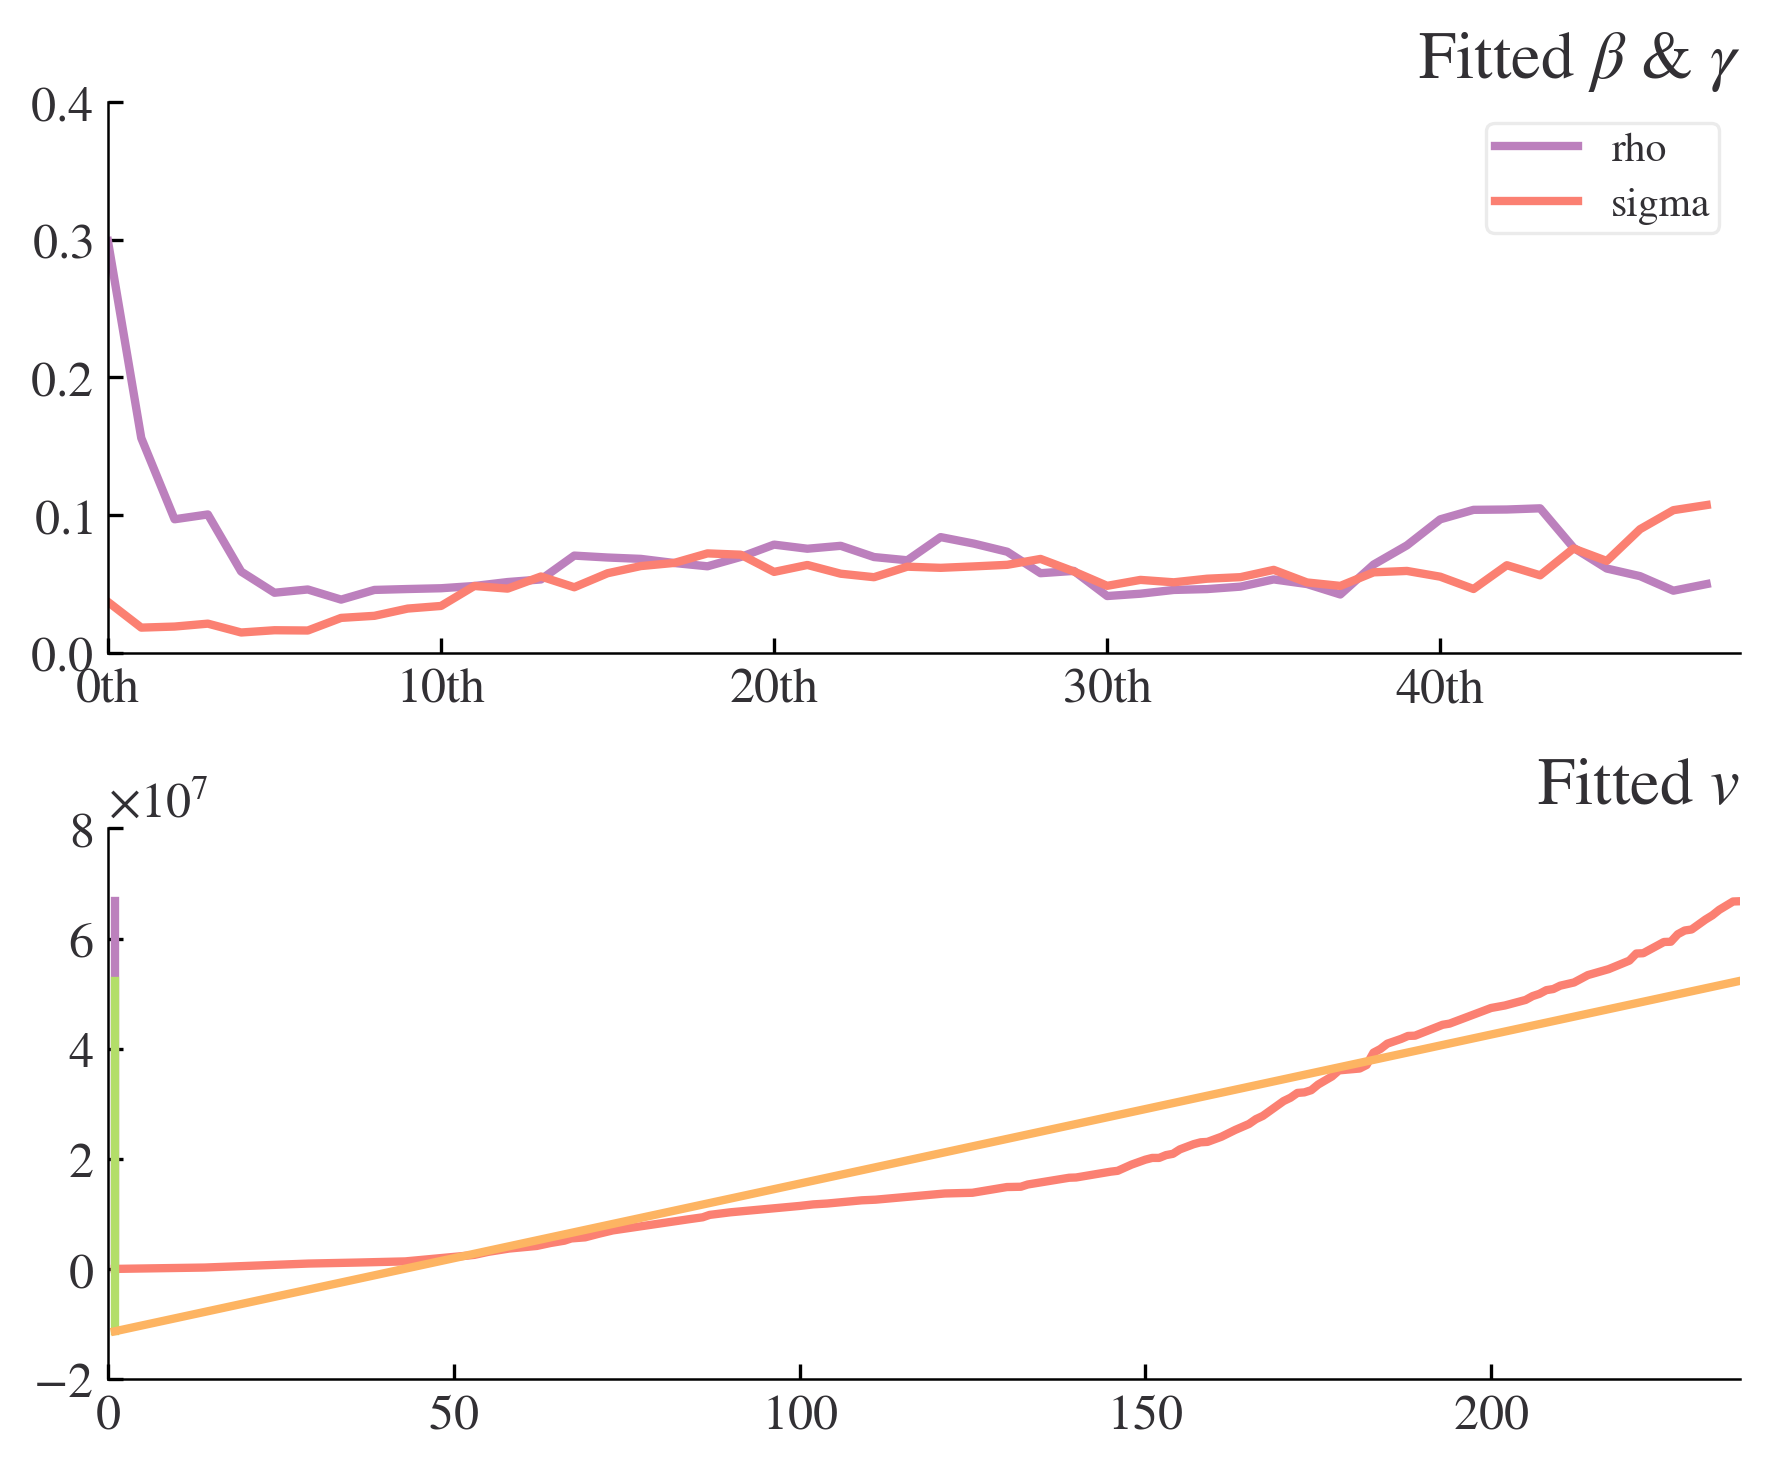

In [25]:
sumdf = snl.summary()
y_pred = scaler.inverse_transform(results.predict(X).reshape(-1, 1))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 5))
sumdf[["rho", "sigma"]].plot(title="Fitted $\\beta$ & $\\gamma$", ax=ax1)
ax1.set_xlim(0, len(sumdf))

ax2.plot(X, scaler.inverse_transform(y))
ax2.plot(X, y_pred)
ax2.set_xlim(0, len(y_pred))
ax2.set_title("Fitted $v$")

plt.tight_layout()
plt.show()